In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from torch.nn import functional as f
from torch.utils.data import TensorDataset, DataLoader
import psycopg2
from pgvector.psycopg2 import register_vector
from config import HOST, DBNAME, USERNAME, PASSWORD

/home/nicek/Projects/multitask_learning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_proj_default(latent, labels):
    latent = latent / np.linalg.norm(latent, axis=1, keepdims=True)
    # latent = low_rank_approximation(latent, 2)
    latent_2d = PCA(n_components=2).fit_transform(latent)
    _, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(
        latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.7
    )
    plt.colorbar(scatter, label="Label ID")
    plt.xlabel("latend_2d[:, 0]")
    plt.ylabel("latend_2d[:, 1]")
    plt.title("Latent space visualization")
    plt.show()

In [3]:
def low_rank_approximation(embedding: np.ndarray, k: int):
    U, S, Vt = np.linalg.svd(embedding, full_matrices=False)
    return U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

In [4]:
def low_rank_projection(embedding: np.ndarray, k: int):
    U, S, Vt = np.linalg.svd(embedding, full_matrices=False)
    return U[:, :k] * S[:k] 

In [5]:
def random_projection(latent: np.ndarray, k: int):
    latent = latent / np.linalg.norm(latent, axis=1, keepdims=True)
    R = np.random.randn(384, k) / np.sqrt(k)
    return latent @ R

In [6]:
def make_dataloader(X, y, batch_size=64):
    tensor_x = torch.tensor(X, dtype=torch.float32)
    tensor_y = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class ClassiNet(nn.Module):
    def __init__(self, input_dim, num_label=2):
        super(ClassiNet, self).__init__()
        self.classi = nn.Linear(input_dim, num_label)
    
    def forward(self, x):
        return self.classi(x)

epochs = 10

# One pass
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for data, label in loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.cross_entropy(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
    return 100 * correct / total

In [8]:
conn = psycopg2.connect(
    host=HOST,
    dbname=DBNAME,
    user=USERNAME,
    password=PASSWORD,
)

split = "_test"
dataset_name = "EmotionClassification" + split

# pgvector query
register_vector(conn)
curr = conn.cursor()
curr.execute(
    """
SELECT * FROM vectors
WHERE dataset_id = (
    SELECT id FROM vector_datasets
    WHERE name = %s
);
""",
    (dataset_name,),
)
tests = curr.fetchall()

split = "_train"
dataset_name = "EmotionClassification" + split

curr.execute(
    """
SELECT * FROM vectors
WHERE dataset_id = (
    SELECT id FROM vector_datasets
    WHERE name = %s
);
""",
    (dataset_name,),
)

trains = curr.fetchall()
curr.close()
conn.close()

train_embedding = np.array([row[2] for row in trains]) # (16000, 384) 
train_labels = np.array([row[5] for row in trains]) # (16000, )
train_labels -= 232

test_embedding = np.array([row[2] for row in tests])  # (2000, 384)
test_labels = np.array([row[5] for row in tests]) # (2000, )
test_labels -= 238

a = input("Label1: ")
a = int(a) if a else -1
b = input("Label2: ")
b = int(b) if b else -1

if a == -1 and b == -1:
    train_mask = test_mask = None
else:
    train_mask = (train_labels == a) | (train_labels == b)
    test_mask = (test_labels == a) | (test_labels == b)
if train_mask is not None and np.any(train_mask) and np.any(test_mask):
    train_embedding = train_embedding[train_mask]
    test_embedding = test_embedding[test_mask]
    train_labels = train_labels[train_mask]
    test_labels = test_labels[test_mask]
    # Map to 0, 1 for ClassiNet <3
    label_map = {a: 0, b: 1}
    train_labels = np.vectorize(label_map.get)(train_labels)
    test_labels = np.vectorize(label_map.get)(test_labels)

print(f"{train_embedding.shape=}")
print(f"{test_embedding.shape=}")

train_embedding.shape=(16000, 384)
test_embedding.shape=(2000, 384)


train_embedding.shape=(16000, 384)
test_embedding.shape=(2000, 384)


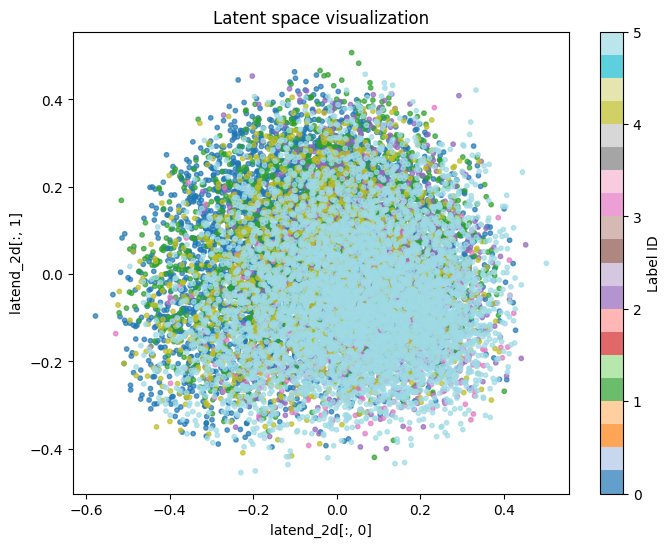

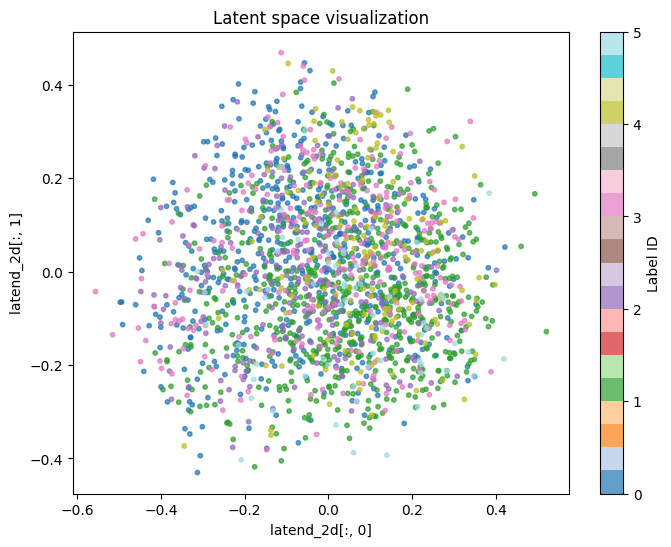

In [9]:
print(f"{train_embedding.shape=}")
print(f"{test_embedding.shape=}")
plot_proj_default(train_embedding, train_labels)
plot_proj_default(test_embedding, test_labels)


[LOG] Running for k = 1


Epoch 5: Loss=1.5754 | Test Acc=3.30%
Epoch 10: Loss=1.5666 | Test Acc=3.30%

[LOG] Running for k = 2
Epoch 5: Loss=1.5716 | Test Acc=5.80%
Epoch 10: Loss=1.5544 | Test Acc=4.55%

[LOG] Running for k = 3
Epoch 5: Loss=1.5300 | Test Acc=4.30%
Epoch 10: Loss=1.5060 | Test Acc=5.20%

[LOG] Running for k = 4
Epoch 5: Loss=1.4889 | Test Acc=24.75%
Epoch 10: Loss=1.4451 | Test Acc=15.85%

[LOG] Running for k = 5
Epoch 5: Loss=1.4838 | Test Acc=11.10%
Epoch 10: Loss=1.4244 | Test Acc=11.10%

[LOG] Running for k = 6
Epoch 5: Loss=1.4908 | Test Acc=3.35%
Epoch 10: Loss=1.4064 | Test Acc=4.40%

[LOG] Running for k = 7
Epoch 5: Loss=1.4477 | Test Acc=7.65%
Epoch 10: Loss=1.3588 | Test Acc=8.40%

[LOG] Running for k = 8
Epoch 5: Loss=1.4346 | Test Acc=9.40%
Epoch 10: Loss=1.3481 | Test Acc=9.25%

[LOG] Running for k = 9
Epoch 5: Loss=1.4216 | Test Acc=21.85%
Epoch 10: Loss=1.3342 | Test Acc=16.20%

[LOG] Running for k = 10
Epoch 5: Loss=1.4123 | Test Acc=12.65%
Epoch 10: Loss=1.3180 | Test Acc=11.

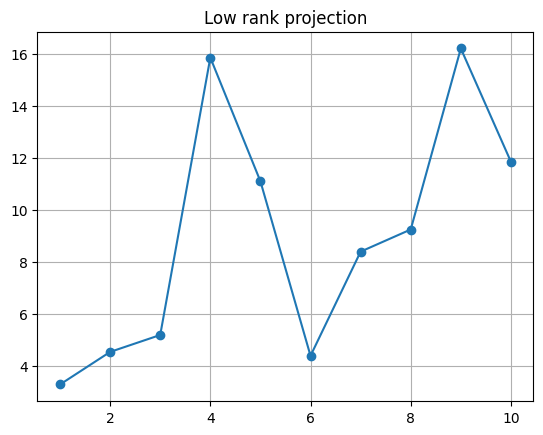

In [10]:
# Same old function
K = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10]
results = []

for k in K:
    print(f"\n[LOG] Running for {k = }")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassiNet(k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_loader = make_dataloader(low_rank_projection(train_embedding, k), train_labels)
    test_loader = make_dataloader(low_rank_projection(test_embedding, k), test_labels)

    model = ClassiNet(input_dim=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Low rank projection")
plt.show()


[LOG] Running for k = 1
Epoch 5: Loss=1.6215 | Test Acc=6.60%
Epoch 10: Loss=1.5448 | Test Acc=10.05%

[LOG] Running for k = 2
Epoch 5: Loss=1.5986 | Test Acc=6.00%
Epoch 10: Loss=1.5636 | Test Acc=8.85%

[LOG] Running for k = 3
Epoch 5: Loss=1.5669 | Test Acc=10.85%
Epoch 10: Loss=1.5546 | Test Acc=8.70%

[LOG] Running for k = 4
Epoch 5: Loss=1.5400 | Test Acc=16.25%
Epoch 10: Loss=1.5141 | Test Acc=14.30%

[LOG] Running for k = 5
Epoch 5: Loss=1.5289 | Test Acc=12.30%
Epoch 10: Loss=1.5104 | Test Acc=13.85%

[LOG] Running for k = 6
Epoch 5: Loss=1.5588 | Test Acc=17.45%
Epoch 10: Loss=1.5421 | Test Acc=14.25%

[LOG] Running for k = 7
Epoch 5: Loss=1.5222 | Test Acc=16.85%
Epoch 10: Loss=1.5035 | Test Acc=14.65%

[LOG] Running for k = 8
Epoch 5: Loss=1.5484 | Test Acc=13.05%
Epoch 10: Loss=1.5241 | Test Acc=7.15%

[LOG] Running for k = 9
Epoch 5: Loss=1.5314 | Test Acc=4.20%
Epoch 10: Loss=1.5136 | Test Acc=4.75%

[LOG] Running for k = 10
Epoch 5: Loss=1.5330 | Test Acc=5.15%
Epoch 1

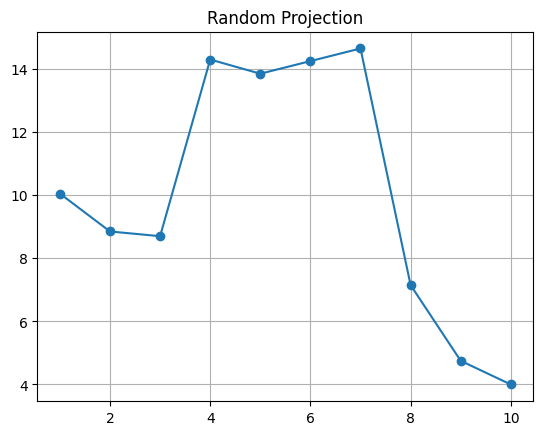

In [11]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10]
results = []

for k in K:
    print(f"\n[LOG] Running for {k = }")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassiNet(k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_loader = make_dataloader(random_projection(train_embedding, k), train_labels)
    test_loader = make_dataloader(random_projection(test_embedding, k), test_labels)

    model = ClassiNet(input_dim=k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Random Projection")
plt.show()


[LOG] Running for k = 1


Epoch 5: Loss=1.5699 | Test Acc=13.85%
Epoch 10: Loss=1.5636 | Test Acc=16.00%

[LOG] Running for k = 2
Epoch 5: Loss=1.5549 | Test Acc=14.70%
Epoch 10: Loss=1.5501 | Test Acc=17.55%

[LOG] Running for k = 3
Epoch 5: Loss=1.4978 | Test Acc=19.70%
Epoch 10: Loss=1.4938 | Test Acc=20.00%

[LOG] Running for k = 4
Epoch 5: Loss=1.4127 | Test Acc=21.75%
Epoch 10: Loss=1.4088 | Test Acc=22.30%

[LOG] Running for k = 5
Epoch 5: Loss=1.3835 | Test Acc=20.85%
Epoch 10: Loss=1.3778 | Test Acc=20.15%

[LOG] Running for k = 6
Epoch 5: Loss=1.3432 | Test Acc=20.15%
Epoch 10: Loss=1.3325 | Test Acc=20.90%

[LOG] Running for k = 7
Epoch 5: Loss=1.2878 | Test Acc=21.55%
Epoch 10: Loss=1.2728 | Test Acc=20.85%

[LOG] Running for k = 8
Epoch 5: Loss=1.2792 | Test Acc=22.35%
Epoch 10: Loss=1.2634 | Test Acc=21.95%

[LOG] Running for k = 9
Epoch 5: Loss=1.2656 | Test Acc=21.65%
Epoch 10: Loss=1.2469 | Test Acc=21.55%

[LOG] Running for k = 10
Epoch 5: Loss=1.2499 | Test Acc=22.60%
Epoch 10: Loss=1.2295 | 

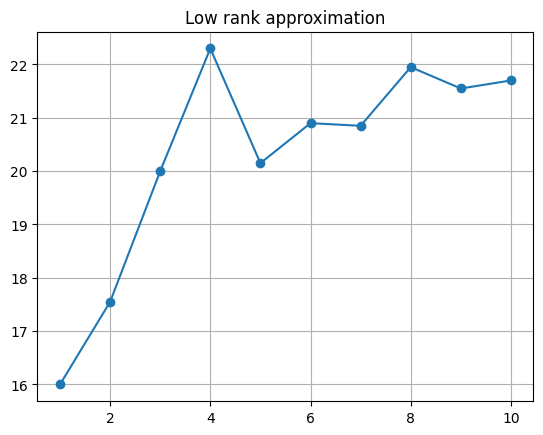

In [12]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10]
results = []

for k in K:
    print(f"\n[LOG] Running for {k = }")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ClassiNet(k).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_loader = make_dataloader(low_rank_approximation(train_embedding, k), train_labels)
    test_loader = make_dataloader(low_rank_approximation(test_embedding, k), test_labels)

    model = ClassiNet(input_dim=384).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        loss = train(model, train_loader, optimizer, device)
        if (epoch + 1) % 5 == 0:
            acc = test(model, test_loader, device)
            print(f"Epoch {epoch+1}: Loss={loss:.4f} | Test Acc={acc:.2f}%")
    
    final_acc = test(model, test_loader, device)
    results.append((k, final_acc))

dims, accs = zip(*results)
plt.plot(dims, accs, marker='o')
plt.grid(True)
plt.title("Low rank approximation")
plt.show()